In [1]:
import numpy as np
import pandas as pd  
import xarray as xr 
import matplotlib.pyplot as plt 

In [7]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [21]:
def get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta))
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    dsrmm0 = xr.open_dataset(fnRMM)
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem1d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC for each MCDO
        r1p = np.asarray(dsfn_sel['RMMp_dis'][:,:,0]).squeeze()
        r2p = np.asarray(dsfn_sel['RMMp_dis'][:,:,1]).squeeze()

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # # calculate BCC for each MCDO
        # r1p = np.asarray(dsfn_sel['RMMp'][:,0])
        # r2p = np.asarray(dsfn_sel['RMMp'][:,1])

        # r1t = np.asarray(dsfn_sel['RMMt'][:,0])
        # r2t = np.asarray(dsfn_sel['RMMt'][:,1])

        # print(np.shape(r1p))
        # print(np.shape(r2t))

        # BCC  [Nsamp]
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append(d)

        # amplitude error [time, Nsamp] prediction - truth
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = a - b 
        amp_err.append(c)

        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err

In [22]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1

BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))

In [23]:
np.shape(BCC)

(8, 100)

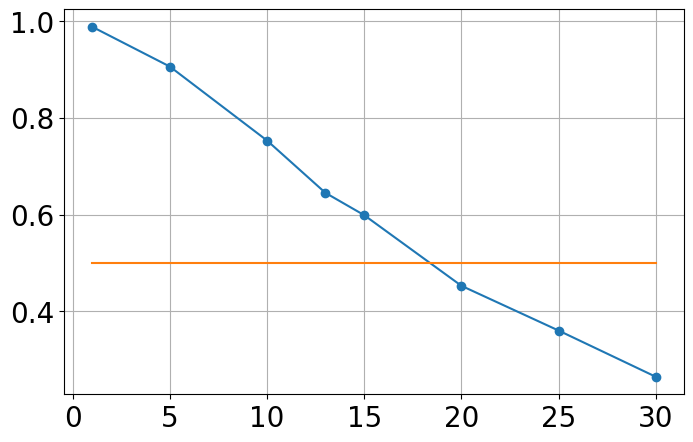

In [18]:
# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(8,5))
# gs = fig.add_gridspec(1, 1, hspace=0.05, wspace=0.2)
# ax = gs.subplots()
# plt.rcParams.update({'font.size': 20})

# ax.plot(lead, BCC, 'o-')
# ax.plot(lead, 0.5 * np.ones(len(lead)))
# ax.grid(visible=True)


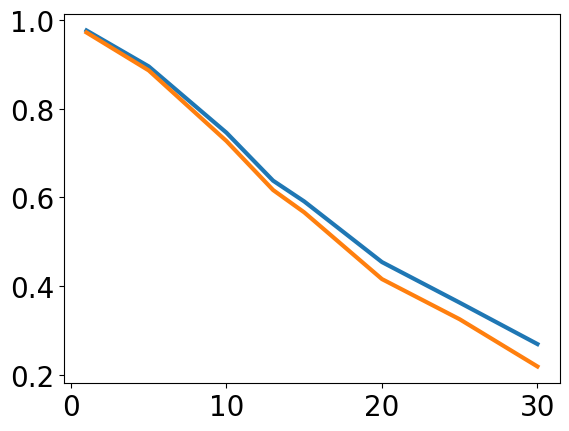

In [24]:
BCC_max = np.max(np.asarray(BCC), axis=1)
BCC_min = np.min(np.asarray(BCC), axis=1)

plt.plot(lead, BCC_max, linewidth=3)
plt.plot(lead, BCC_min, linewidth=3)

In [11]:
BCC_max

0.9878801897020143

In [70]:
RMSEav = np.mean(np.asarray(RMSE), axis=1)

In [71]:
RMSEav_max = np.max(np.asarray(RMSEav), axis=1)
RMSEav_min = np.min(np.asarray(RMSEav), axis=1)

RMSEav_max

array([3.21287405])

In [19]:
ds = xr.open_dataset('/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead20_dailyinput_mem1d.nc')
RMMp = ds['RMMp']

In [20]:
RMMp[:11,:] 

<xarray.DataArray 'RMMp' (time: 11, mode: 2)>
array([[ 0.91702 ,  0.835976],
       [ 0.827929,  0.928605],
       [ 0.711667,  1.000631],
       [ 0.583504,  1.115329],
       [ 0.317721,  1.140516],
       [-0.270069,  1.212079],
       [-0.73874 ,  1.115304],
       [-0.845211,  0.604455],
       [-0.958164,  0.284645],
       [-0.745804,  0.59546 ],
       [-0.664509,  0.788396]])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-01-11
  * mode     (mode) int64 0 1
Attributes:
    description:  RMM prediction

In [81]:
ds['RMMt'][:11,:] 

<xarray.DataArray 'RMMt' (time: 11, mode: 2)>
array([[-1.225615,  0.400374],
       [-1.275347, -0.027117],
       [-1.49404 , -0.303494],
       [-1.861554, -0.596937],
       [-2.042822, -0.598987],
       [-2.27774 , -0.582565],
       [-2.481107, -1.034657],
       [-2.408826, -1.261341],
       [-2.158048, -1.291546],
       [-1.802836, -1.482308],
       [-1.22119 , -1.326488]])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-01-11
  * mode     (mode) int64 0 1
Attributes:
    description:  RMM truth

In [88]:
fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc' 
dsrmm0 = xr.open_dataset(fnRMM)
dsrmm = dsrmm0.sel(time=slice('2015-01-01', '2015-01-11'))

dsrmm['RMM']

<xarray.DataArray 'RMM' (time: 11, mode: 2)>
array([[-1.388955,  0.579924],
       [-1.225615,  0.400374],
       [-1.275347, -0.027117],
       [-1.49404 , -0.303494],
       [-1.861554, -0.596937],
       [-2.042822, -0.598987],
       [-2.27774 , -0.582565],
       [-2.481107, -1.034657],
       [-2.408826, -1.261341],
       [-2.158048, -1.291546],
       [-1.802836, -1.482308]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-01-11
    dayofyear  (time) int64 ...
  * mode       (mode) int64 0 1

In [89]:
fnRMM='/global/homes/l/linyaoly/ERA5/reanalysis/data_preproc/RMM_ERA5_daily_1979to2020_base1979.nc'
dsrmm0 = xr.open_dataset(fnRMM)
dsrmm = dsrmm0.sel(time=slice('2015-01-01', '2015-01-11'))

dsrmm['RMM']

<xarray.DataArray 'RMM' (time: 11, mode: 2)>
array([[-1.320029,  0.651942],
       [-1.172435,  0.464243],
       [-1.248154,  0.056447],
       [-1.476891, -0.191714],
       [-1.864507, -0.445296],
       [-2.040707, -0.429162],
       [-2.244629, -0.38179 ],
       [-2.450826, -0.796413],
       [-2.397124, -1.029347],
       [-2.17273 , -1.091102],
       [-1.847916, -1.299894]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-01-11
    dayofyear  (time) int64 ...
  * mode       (mode) int64 0 1